### Import Necessary Dependencies

In [1]:
#Import libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist

import string

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from keras import optimizers
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

np.random.seed(0)

%matplotlib inline
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /Users/Filip/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Filip/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using TensorFlow backend.


### Read and Load the Dataset

In [2]:
# Upload datasets
df = pd.read_csv('tweet_product_company.csv', encoding = 'unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


### Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [4]:
len(df.emotion_in_tweet_is_directed_at.unique())

10

In [5]:
df.columns = ['tweet_text', 'product', 'label']
df.head()

,tweet_text,product,label
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [6]:
for column in df.columns[1:]:
    print('Column: ', column)
    print('Unique values count:', len(df[column].unique()))
    print('Values: ', df[column].unique())
    print('----------------')

Column:  product
Unique values count: 10
Values:  ['iPhone' 'iPad or iPhone App' 'iPad' 'Google' nan 'Android' 'Apple'
 'Android App' 'Other Google product or service'
 'Other Apple product or service']
----------------
Column:  label
Unique values count: 4
Values:  ['Negative emotion' 'Positive emotion'
 'No emotion toward brand or product' "I can't tell"]
----------------


In [7]:
# Create summary of Nan and unique values counts and data types
X_info = pd.DataFrame(df.isna().sum(), columns=['NaN count'])

unique_val = []
types_val = []
zero_val = []

for column in df.columns:
    unique = df[column].nunique()
    types = str(df[column].dtype)
    zeros = len(df[df[column]==0])
    
    unique_val.append(unique)
    types_val.append(types)
    zero_val.append(zeros)

X_info['Zero values count'] = zero_val
X_info['Unique_val count'] = unique_val
X_info['Data type'] = types_val

X_info.sort_values(by=['NaN count', 'Zero values count'], ascending=False)

,NaN count,Zero values count,Unique_val count,Data type
product,5802,0,9,object
tweet_text,1,0,9065,object
label,0,0,4,object


### Data Visualization of Target Variables

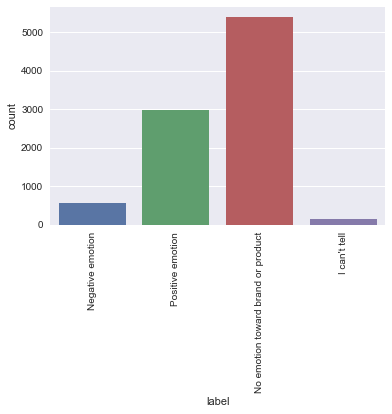

In [8]:
ax = sns.countplot(x='label', data=df)
ax.tick_params(axis='x', rotation=90)

In [9]:
df['label'].value_counts(normalize=True)

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: label, dtype: float64

In [10]:
df.groupby(by=['product']).count()

,tweet_text,label
product,,
Android,78,78
Android App,81,81
Apple,661,661
Google,430,430
Other Apple product or service,35,35
Other Google product or service,293,293
iPad,946,946
iPad or iPhone App,470,470
iPhone,297,297


### Cleaning and Preprocessing Data

#### Dropping a NaN values for 'tweet_text' column

- Do we remove stop words or not?
- Do we stem or lemmatize our text data, or leave the words as is?
- Is basic tokenization enough, or do we need to support special edge cases through the use of regex?
- Do we use the entire vocabulary, or just limit the model to a subset of the most frequently used words? If so, how many?
- Do we engineer other features, such as bigrams, or POS tags, or Mutual Information Scores?
- What sort of vectorization should we use in our model? Boolean Vectorization? Count Vectorization? TF-IDF? More advanced vectorization strategies such as Word2Vec?

In [11]:
df.dropna(subset=['tweet_text'], axis='rows', inplace=True)

#### Break apart the data and the labels, and then inspect the class names

In [12]:
data = df.drop(columns=['label','product'])
# data = data.to_frame()
target = df.drop(columns=['tweet_text','product'])
# target = target.to_frame()

In [13]:
#change type of column
target['label'] = pd.Categorical(target['label'])

In [14]:
target['label'] = target['label'].cat.codes

In [15]:
label_names = list(target['label'].unique())
label_names

[1, 3, 2, 0]

In [16]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=42)

In [17]:
print(y_train.shape)
y_train

(6819, 1)


,label
8605,1
1303,2
8759,3
5021,2
3210,2
...,...
5735,2
5192,3
5391,2
861,3


In [18]:
print(X_train.shape)
X_train.head()

(6819, 1)


,tweet_text
8605,Perfect attention to detail RT @mention Google...
1303,my iphone was stolen and I got it back !!!!!! ...
8759,fuck I love Austin. Just left the Youtube Goog...
5021,Spotted something rare a few minutes ago...a p...
3210,@mention fyi RT @mention I'll be at the Austi...


#### Check tweet lenghts distrubution and max value

max phrase len: 33


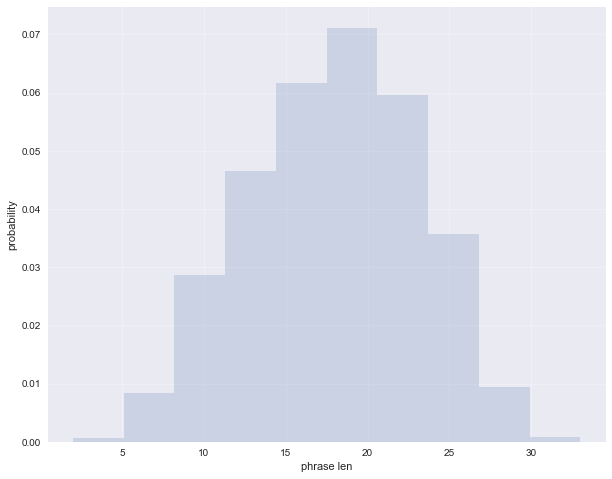

In [19]:
phrase_len = X_train['tweet_text'].apply(lambda p: len(p.split(' ')))
max_phrase_len = phrase_len.max()
print('max phrase len: {0}'.format(max_phrase_len))

#Plot results
plt.figure(figsize = (10, 8))
plt.hist(phrase_len, alpha = 0.2, density = True)
plt.xlabel('phrase len')
plt.ylabel('probability')
plt.grid(alpha = 0.25)

#### Tokenize tweets

In [20]:
# Raw text tweets
tweets_train = X_train['tweet_text']

# Initialize a tokenizer 
tokenizer = Tokenizer(num_words=2000) 

# Fit it to the complaints
tokenizer.fit_on_texts(tweets_train) 

# Generate sequences
sequences = tokenizer.texts_to_sequences(tweets_train) 
print('sequences type:', type(sequences))

sequences type: <class 'list'>


In [21]:
# print(tokenizer.word_index)

In [22]:
#Truncate and pad input sequences to be all the same lenght vectors
X_train = pad_sequences(sequences, maxlen=max_phrase_len)

#Convert class vector (integers) to binary class matrix
y_train = to_categorical(y_train)

In [23]:
X_train

array([[   0,    0,    0, ..., 1020,    1, 1575],
       [   0,    0,    0, ...,   32,  203,    1],
       [   0,    0,    0, ...,  525,    1,   25],
       ...,
       [   0,    0,    0, ...,   17,   43,   12],
       [   0,    0,    0, ...,   16,   64,   22],
       [   0,    0,    0, ...,   93,   50,    1]], dtype=int32)

In [24]:
X_train.shape

(6819, 33)

In [25]:
y_train.shape

(6819, 4)

### LSTM Model 1

In [26]:
model_lstm = models.Sequential()

model_lstm.add(Embedding(input_dim = 2000, output_dim = 256, input_length = max_phrase_len))
model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(256, dropout = 0.3, recurrent_dropout = 0.3))
model_lstm.add(Dense(256, activation = 'relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(4, activation = 'softmax'))

model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

In [27]:
history = model_lstm.fit(
    X_train,
    y_train,
    validation_split = 0.2,
    epochs = 8,
    batch_size = 512
)

Train on 5455 samples, validate on 1364 samples
Epoch 1/8
5455/5455 [==============================] - 20s 4ms/step - loss: 1.1421 - acc: 0.5621 - val_loss: 0.9254 - val_acc: 0.6070
Epoch 2/8
5455/5455 [==============================] - 18s 3ms/step - loss: 0.9110 - acc: 0.5901 - val_loss: 0.8857 - val_acc: 0.6070
Epoch 3/8
5455/5455 [==============================] - 18s 3ms/step - loss: 0.8755 - acc: 0.5960 - val_loss: 0.8668 - val_acc: 0.6100
Epoch 4/8
5455/5455 [==============================] - 18s 3ms/step - loss: 0.8393 - acc: 0.6082 - val_loss: 0.8656 - val_acc: 0.6026
Epoch 5/8
5455/5455 [==============================] - 19s 4ms/step - loss: 0.7966 - acc: 0.6411 - val_loss: 0.8402 - val_acc: 0.6305
Epoch 6/8
5455/5455 [==============================] - 18s 3ms/step - loss: 0.7283 - acc: 0.6790 - val_loss: 0.8292 - val_acc: 0.6312
Epoch 7/8
5455/5455 [==============================] - 18s 3ms/step - loss: 0.6623 - acc: 0.7219 - val_loss: 0.8618 - val_acc: 0.6371
Epoch 8/8
5455

#### Visualize training results

In [28]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

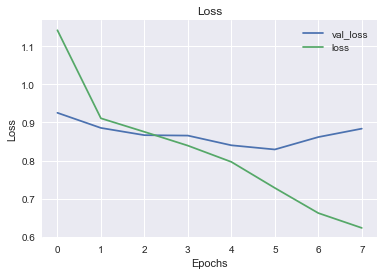

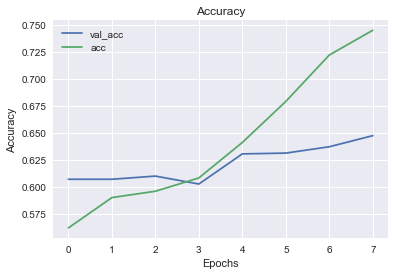

In [29]:
visualize_training_results(history)

### LSTM Model 2

#### Early Stopping

In [30]:
# Import EarlyStopping and ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model_2.h5', monitor='val_loss', save_best_only=True)]

In [31]:
model_lstm_2 = models.Sequential()

model_lstm_2.add(Embedding(input_dim = 2000, output_dim = 50, input_length = max_phrase_len))
model_lstm_2.add(Dropout(0.3))
# model_lstm_2.add(SpatialDropout1D(0.3))
model_lstm_2.add(LSTM(50))
model_lstm_2.add(Dropout(0.3))
model_lstm_2.add(Dense(25, activation = 'relu'))
model_lstm_2.add(Dropout(0.3))

model_lstm_2.add(Dense(4, activation = 'softmax'))

model_lstm_2.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [32]:
history = model_lstm_2.fit(
    X_train,
    y_train,
    validation_split = 0.2,
    callbacks=early_stopping,
    epochs = 32,
    batch_size = 1000
)

Train on 5455 samples, validate on 1364 samples
Epoch 1/32
5455/5455 [==============================] - 3s 502us/step - loss: 1.3813 - acc: 0.3716 - val_loss: 1.3615 - val_acc: 0.6070
Epoch 2/32
5455/5455 [==============================] - 2s 324us/step - loss: 1.3463 - acc: 0.5859 - val_loss: 1.3112 - val_acc: 0.6070
Epoch 3/32
5455/5455 [==============================] - 2s 315us/step - loss: 1.2849 - acc: 0.5897 - val_loss: 1.1988 - val_acc: 0.6070
Epoch 4/32
5455/5455 [==============================] - 2s 309us/step - loss: 1.1344 - acc: 0.5879 - val_loss: 0.9467 - val_acc: 0.6070
Epoch 5/32
5455/5455 [==============================] - 2s 310us/step - loss: 1.0304 - acc: 0.5844 - val_loss: 0.9080 - val_acc: 0.6070
Epoch 6/32
5455/5455 [==============================] - 2s 308us/step - loss: 0.9803 - acc: 0.5569 - val_loss: 0.9222 - val_acc: 0.6070
Epoch 7/32
5455/5455 [==============================] - 2s 307us/step - loss: 0.9757 - acc: 0.5397 - val_loss: 0.9123 - val_acc: 0.6070


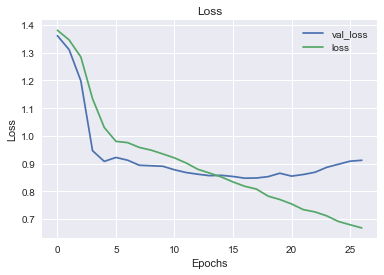

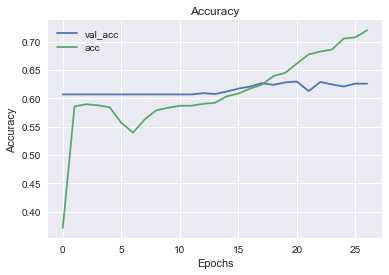

In [33]:
visualize_training_results(history)

### LSTM Model 3

In [34]:
# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model_3.h5', monitor='val_loss', save_best_only=True)]

In [35]:
model_lstm_3 = models.Sequential()

model_lstm_3.add(Embedding(input_dim = 2000, output_dim = 50, input_length = max_phrase_len))
model_lstm_3.add(Dropout(0.3))
model_lstm_3.add(LSTM(50))
model_lstm_3.add(Dropout(0.3))
model_lstm_3.add(Dense(25, activation = 'relu'))
model_lstm_3.add(Dropout(0.3))

model_lstm_3.add(Dense(4, activation = 'softmax'))

model_lstm_3.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [36]:
history_3 = model_lstm_3.fit(
    X_train,
    y_train,
    validation_split = 0.2,
    callbacks=early_stopping,
    epochs = 32,
    batch_size = 1000
)

Train on 5455 samples, validate on 1364 samples
Epoch 1/32
5455/5455 [==============================] - 3s 530us/step - loss: 1.3726 - acc: 0.4829 - val_loss: 1.3457 - val_acc: 0.6063
Epoch 2/32
5455/5455 [==============================] - 2s 311us/step - loss: 1.3242 - acc: 0.5863 - val_loss: 1.2767 - val_acc: 0.6070
Epoch 3/32
5455/5455 [==============================] - 2s 351us/step - loss: 1.2378 - acc: 0.5846 - val_loss: 1.1328 - val_acc: 0.6070
Epoch 4/32
5455/5455 [==============================] - 2s 317us/step - loss: 1.0643 - acc: 0.5839 - val_loss: 0.9159 - val_acc: 0.6070
Epoch 5/32
5455/5455 [==============================] - 2s 312us/step - loss: 1.0031 - acc: 0.5842 - val_loss: 0.9032 - val_acc: 0.6070
Epoch 6/32
5455/5455 [==============================] - 2s 311us/step - loss: 0.9651 - acc: 0.5791 - val_loss: 0.9211 - val_acc: 0.6070
Epoch 7/32
5455/5455 [==============================] - 2s 321us/step - loss: 0.9586 - acc: 0.5852 - val_loss: 0.8977 - val_acc: 0.6070


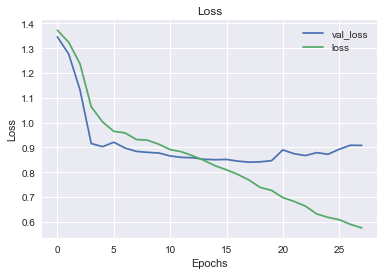

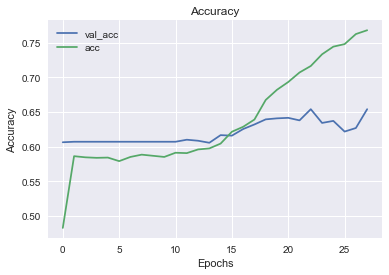

In [37]:
visualize_training_results(history_3)

### LSTM Model 4

#### Further clean up of tweets' content and removal of stopwords

In [38]:
# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model_4.h5', monitor='val_loss', save_best_only=True)]

In [39]:
# #### Getting a list of all of the english stopwords, and concatenating them with a list of all the punctuation.
stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``']

In [40]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=42)

In [41]:
def process_tweet(tweet):
    tokens = nltk.word_tokenize(tweet)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return stopwords_removed

In [42]:
processed_data = X_train.applymap(process_tweet)

In [43]:
processed_data['tweet_text'] = processed_data['tweet_text'].apply(lambda x: ' '.join(map(str, x)))
processed_data

,tweet_text
8605,perfect attention detail rt mention google rec...
1303,iphone stolen got back sxsw
8759,fuck love austin left youtube google party mag...
5021,spotted something rare minutes ago phone made ...
3210,mention fyi rt mention 'll austin convention c...
...,...
5735,rt mention notatsxsw sxsw 's link free downloa...
5192,rt mention quot future local contextual discov...
5391,rt mention android may gaining market share 'd...
861,mention love mention mention sxsw quot apple c...


#### Tokenize tweets

In [44]:
# Raw text tweets
tweets_train = processed_data['tweet_text']

# Initialize a tokenizer 
tokenizer = Tokenizer(num_words=2000) 

# Fit it to the complaints
tokenizer.fit_on_texts(tweets_train) 

# Generate sequences
train_sequences = tokenizer.texts_to_sequences(tweets_train) 
print('sequences type:', type(sequences))

sequences type: <class 'list'>


In [45]:
#Truncate and pad input sequences to be all the same lenght vectors
X_train = pad_sequences(train_sequences, maxlen=max_phrase_len)

y_train = to_categorical(y_train)

In [46]:
model_lstm_4 = models.Sequential()

model_lstm_4.add(Embedding(input_dim = 2000, output_dim = 50, input_length = max_phrase_len))
model_lstm_4.add(Dropout(0.3))
model_lstm_4.add(LSTM(50))
model_lstm_4.add(Dropout(0.3))
model_lstm_4.add(Dense(5, activation = 'relu'))
model_lstm_4.add(Dropout(0.3))

model_lstm_4.add(Dense(4, activation = 'softmax'))

model_lstm_4.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [47]:
history_4 = model_lstm_4.fit(
    X_train,
    y_train,
    validation_split = 0.2,
    callbacks=early_stopping,
    epochs = 45,
    batch_size = 700
)

Train on 5455 samples, validate on 1364 samples
Epoch 1/45
5455/5455 [==============================] - 3s 574us/step - loss: 1.3795 - acc: 0.4108 - val_loss: 1.3615 - val_acc: 0.6041
Epoch 2/45
5455/5455 [==============================] - 2s 328us/step - loss: 1.3410 - acc: 0.5368 - val_loss: 1.2959 - val_acc: 0.6070
Epoch 3/45
5455/5455 [==============================] - 2s 325us/step - loss: 1.2152 - acc: 0.5234 - val_loss: 1.0064 - val_acc: 0.6070
Epoch 4/45
5455/5455 [==============================] - 2s 323us/step - loss: 1.0634 - acc: 0.5219 - val_loss: 0.9153 - val_acc: 0.6070
Epoch 5/45
5455/5455 [==============================] - 2s 318us/step - loss: 1.0383 - acc: 0.5327 - val_loss: 0.9254 - val_acc: 0.6070
Epoch 6/45
5455/5455 [==============================] - 2s 324us/step - loss: 1.0301 - acc: 0.5472 - val_loss: 0.9286 - val_acc: 0.6070
Epoch 7/45
5455/5455 [==============================] - 2s 325us/step - loss: 1.0354 - acc: 0.5331 - val_loss: 0.9275 - val_acc: 0.6070


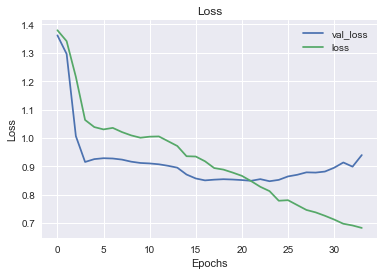

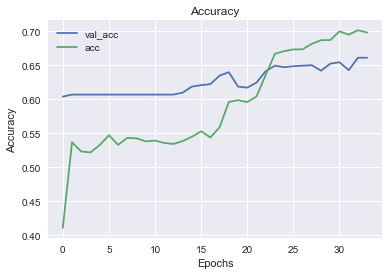

In [48]:
visualize_training_results(history_4)

### Final LMST Model

In [49]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=42)

In [50]:
train_processed_data = X_train.applymap(process_tweet)
test_processed_data = X_test.applymap(process_tweet)

In [51]:
train_processed_data['tweet_text'] = train_processed_data['tweet_text'].apply(lambda x: ' '.join(map(str, x)))
test_processed_data['tweet_text'] = test_processed_data['tweet_text'].apply(lambda x: ' '.join(map(str, x)))

train_processed_data.head()

,tweet_text
8605,perfect attention detail rt mention google rec...
1303,iphone stolen got back sxsw
8759,fuck love austin left youtube google party mag...
5021,spotted something rare minutes ago phone made ...
3210,mention fyi rt mention 'll austin convention c...


In [52]:
test_processed_data.head()

,tweet_text
7169,google close launching new social network circ...
2089,iphone charging sxsw link
2303,walk lady bird lake lovely google maps travel ...
928,ûï mention rumor apple popup store downtown a...
5895,rt mention google launch major new social netw...


In [53]:
# Raw text tweets
tweets_train = train_processed_data['tweet_text']
tweets_test = test_processed_data['tweet_text']

# Initialize a tokenizer 
tokenizer = Tokenizer(num_words=2000) 

# Fit it to the tweets train
tokenizer.fit_on_texts(tweets_train)
# Generate sequences
train_sequences = tokenizer.texts_to_sequences(tweets_train)

# Fit it to the tweets test
tokenizer.fit_on_texts(tweets_test) 
# Generate sequences
test_sequences = tokenizer.texts_to_sequences(tweets_test) 

print('sequences type:', type(train_sequences))

sequences type: <class 'list'>


In [54]:
#Truncate and pad input sequences to be all the same lenght vectors
X_train = pad_sequences(train_sequences, maxlen=max_phrase_len)
X_test = pad_sequences(test_sequences, maxlen=max_phrase_len)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [55]:
X_test.shape

(2273, 33)

In [56]:
y_test.shape

(2273, 4)

In [57]:
model_lstm_final = models.Sequential()

model_lstm_final.add(Embedding(input_dim = 2000, output_dim = 50, input_length = max_phrase_len))
model_lstm_final.add(Dropout(0.3))
model_lstm_final.add(LSTM(50))
model_lstm_final.add(Dropout(0.3))
model_lstm_final.add(Dense(5, activation = 'relu'))
model_lstm_final.add(Dropout(0.3))

model_lstm_final.add(Dense(4, activation = 'softmax'))

model_lstm_final.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [58]:
history_final = model_lstm_final.fit(
    X_train,
    y_train,
#     validation_split = 0.2,
    callbacks=early_stopping,
    epochs = 30,
    batch_size = 700
)

Epoch 1/30
6819/6819 [==============================] - 3s 484us/step - loss: 1.3681 - acc: 0.5216
Epoch 2/30
6819/6819 [==============================] - 2s 305us/step - loss: 1.2663 - acc: 0.5885
Epoch 3/30
6819/6819 [==============================] - 2s 315us/step - loss: 1.1518 - acc: 0.5470
Epoch 4/30
6819/6819 [==============================] - 2s 301us/step - loss: 1.1220 - acc: 0.5678
Epoch 5/30
6819/6819 [==============================] - 2s 298us/step - loss: 1.0973 - acc: 0.5777
Epoch 6/30
6819/6819 [==============================] - 2s 298us/step - loss: 1.0824 - acc: 0.5697
Epoch 7/30
6819/6819 [==============================] - 2s 298us/step - loss: 1.0584 - acc: 0.5693
Epoch 8/30
6819/6819 [==============================] - 2s 327us/step - loss: 1.0232 - acc: 0.5765
Epoch 9/30
6819/6819 [==============================] - 2s 310us/step - loss: 0.9931 - acc: 0.5782
Epoch 10/30
6819/6819 [==============================] - 2s 297us/step - loss: 0.9466 - acc: 0.6105
Epoch 11/

#### Make predictions

In [59]:
# Output (probability) predictions for the test set 
y_hat_test = model_lstm_final.predict(X_test) 

In [60]:
# Print the loss and accuracy for the training set 
results_train = model_lstm_final.evaluate(X_train, y_train)
results_train

6819/6819 [==============================] - 2s 333us/step


[0.5884089549452456, 0.7945446546458135]

In [61]:
# Print the loss and accuracy for the test set 
results_test = model_lstm_final.evaluate(X_test, y_test)
results_test

2273/2273 [==============================] - 1s 302us/step


[1.254975650602115, 0.5587329520457545]

### Best saved model evaluation

In [62]:
from keras.models import load_model
saved_model = load_model('best_model_2.h5')

In [63]:
results_train = saved_model.evaluate(X_train, y_train)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = saved_model.evaluate(X_test, y_test)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

6819/6819 [==============================] - 2s 337us/step
Training Loss: 0.96 
Training Accuracy: 0.592
----------
2273/2273 [==============================] - 1s 290us/step
Test Loss: 0.985 
Test Accuracy: 0.575


In [64]:
saved_model = load_model('best_model_3.h5')
results_train = saved_model.evaluate(X_train, y_train)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = saved_model.evaluate(X_test, y_test)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

6819/6819 [==============================] - 3s 406us/step
Training Loss: 0.991 
Training Accuracy: 0.582
----------
2273/2273 [==============================] - 1s 333us/step
Test Loss: 1.02 
Test Accuracy: 0.56


In [65]:
saved_model = load_model('best_model_4.h5')
results_train = saved_model.evaluate(X_train, y_train)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = saved_model.evaluate(X_test, y_test)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

6819/6819 [==============================] - 3s 377us/step
Training Loss: 0.714 
Training Accuracy: 0.719
----------
2273/2273 [==============================] - 1s 308us/step
Test Loss: 1.0 
Test Accuracy: 0.572
